In [1]:
%load_ext autoreload
%autoreload 2
# %load_ext line_profiler

In [2]:
import pathlib
from ase.io import read
from ase.visualize import view
import matplotlib.pyplot as plt
import numpy as np 
import torch 
torch.set_default_dtype(torch.float64)

import rascaline.torch

import metatensor.torch as mts

from metatensor.torch import Labels, TensorBlock, TensorMap
from metatensor.learn import IndexedDataset, DataLoader
from metatensor.learn.data import group as mts_group, group_and_join as group_and_join_mts

from mlelec.data.dataset import QMDataset, split_by_Aij_mts
from mlelec.utils.twocenter_utils import _to_coupled_basis, lowdin_orthogonalize
from mlelec.utils.pbc_utils import matrix_to_blocks, kmatrix_to_blocks, TMap_bloch_sums, precompute_phase, kblocks_to_matrix, kmatrix_to_blocks, blocks_to_matrix, matrix_to_blocks
from mlelec.utils.plot_utils import print_matrix, matrix_norm, block_matrix_norm, plot_block_errors
from mlelec.features.acdc import compute_features
from mlelec.utils.target_utils import get_targets
from mlelec.models.linear import LinearModelPeriodic
# from mlelec.models.linear_integrated import LinearModelPeriodic
from mlelec.metrics import L2_loss, L2_loss_meanzero

In [ ]:
from mlelec.utils.metatensor_utils import sort_block_hack, sort_hack
from mlelec.utils.pbc_utils import move_orbitals_to_keys

In [3]:
device = 'cpu'

orbitals = {
    'sto-3g': {
               6: [[1,0,0],[2,0,0],[2,1,-1], [2,1,0],[2,1,1]], 
              }, 
    
}

# Dataset

In [144]:
# workdir = './

workdir = f'{pathlib.Path().resolve()}/examples/data/periodic/c2-cp2k-benchmarks'
START = 0 
STOP = 2
SKIP = 1
ORBS = 'sto-3g'
root = f'{workdir}'#/examples/data/periodic/c2/cp2k/sto-3g'
data_dir = root

frames = read(f'{data_dir}/C2_174.extxyz', slice(START, SKIP*STOP, SKIP))
rfock = [np.load(f"{data_dir}/C2_174_881_{i}/realfock_{i}.npy", allow_pickle = True).item() for i in range(START, SKIP*STOP, SKIP)]
rfock0_target = [np.load(f"{data_dir}/baseline/C2_174_881_{i}/realfock_{i}.npy", allow_pickle = True).item() for i in range(START, SKIP*STOP, SKIP)]
rover = [np.load(f"{data_dir}/C2_174_881_{i}/realoverlap_{i}.npy", allow_pickle = True).item() for i in range(START, SKIP*STOP, SKIP)]
# rover0 = [np.load(f"{data_dir}/baseline/C2_174_881_{i}/realoverlap_{i}.npy", allow_pickle = True).item() for i in range(START, STOP)]
kmesh = [8,8,1]

for f in frames:
    f.pbc = [True,True,False]
    f.wrap(center = (0,0,0), eps = 1e-60)
    f.pbc = True

# for K, K0 in zip(rfock, rfock0):
#     for T in K:
#         K[T] = K[T] - K0[T]
rfock_diff_target = []
for K, K0 in zip(rfock, rfock0_target):
    rfock_diff_target.append({})
    for T in K:
        rfock_diff_target[-1][T] = K[T] -K0[T]
        
dataset = QMDataset(frames = frames, 
                               kmesh = kmesh, 
                               dimension = 2,
                               fock_realspace = rfock, 
                               overlap_realspace = rover, 
                               device = device, 
                               orbs = orbitals[ORBS], 
                               orbs_name = 'sto-3g')

In [149]:
cutoff = 20
for ALL_PAIRS in [False,True]:
    for SORT_ORBS in [False, True]:
        try:
            blocks = matrix_to_blocks(dataset, cutoff = cutoff, all_pairs = ALL_PAIRS, sort_orbs=SORT_ORBS)
            rht = blocks_to_matrix(blocks, dataset, all_pairs=ALL_PAIRS, sort_orbs=SORT_ORBS)        
            for ifr in range(len(dataset.fock_realspace)):
                for T in dataset.fock_realspace[ifr]:
                    # print(np.linalg.norm(kfock[ifr][ik] -kfock[ifr][ik].conj().T))
                    # print(np.linalg.norm(kfock[ifr][ik]-rhk[ifr][ik].numpy()))
                    assert (np.linalg.norm(dataset.fock_realspace[ifr][T]-rht[ifr][T].numpy()))<1e-10, (ALL_PAIRS, SORT_ORBS,np.linalg.norm(dataset.fock_realspace[ifr][T]-rht[ifr][T].numpy()))
            print(ALL_PAIRS, SORT_ORBS, 'passed')
        except Exception as e:
            print(e)
            print(ALL_PAIRS, SORT_ORBS, 'failed - moving on')
            continue

False False passed
False True passed
True False passed
True True passed


In [346]:
for ALL_PAIRS in [True, False]:
    for SORT_ORBS in [True, False]:
        try:
            kblocks = kmatrix_to_blocks(dataset, cutoff = cutoff, all_pairs = ALL_PAIRS, sort_orbs=SORT_ORBS)
            rhk = kblocks_to_matrix(kblocks, dataset, all_pairs=ALL_PAIRS, sort_orbs=SORT_ORBS)        
            for ifr in range(len(dataset.fock_kspace)):
                for ik in range(len(dataset.fock_kspace[ifr])):
                    # print(np.linalg.norm(kfock[ifr][ik] -kfock[ifr][ik].conj().T))
                    # print(np.linalg.norm(kfock[ifr][ik]-rhk[ifr][ik].numpy()))
                    assert (np.linalg.norm(dataset.fock_kspace[ifr][ik]-rhk[ifr][ik].numpy()))<1e-13, (ALL_PAIRS, SORT_ORBS,np.linalg.norm(dataset.fock_kspace[ifr][ik]-rhk[ifr][ik].numpy()))
            print(ALL_PAIRS, SORT_ORBS, 'passed')
        except Exception as e:
            print(e)
            print(ALL_PAIRS, SORT_ORBS, 'failed - moving on')
            continue

True True passed
True False passed
False True passed
False False passed


In [347]:
# blocks = matrix_to_blocks(dataset, cutoff = cutoff, all_pairs = False, sort_orbs=True)
kblocks = kmatrix_to_blocks(dataset, cutoff = cutoff, all_pairs = False, sort_orbs=True)
rhk = kblocks_to_matrix(kblocks, dataset, all_pairs=False, sort_orbs=True)        

/media/nigam/b5749eb7-d3f1-4495-adeb-2c318fb7d0de/MAC/mlelec/src/mlelec/utils/pbc_utils.py:1582: SyntaxWarning: invalid escape sequence '\d'
  


In [340]:
print(kblocks.keys[2])
print(kblocks[2].samples[3])
kblocks[2].values[3]/(np.sqrt(2))

LabelsEntry(block_type=1, species_i=6, n_i=1, l_i=0, species_j=6, n_j=2, l_j=0)
LabelsEntry(structure=0, center=0, neighbor=0, kpoint=1)


tensor([[[-2.8136+0.j]]])

In [337]:
kblocks[3].samples

Labels(
    structure  center  neighbor  kpoint
        0        0        1        0
        0        0        1        1
        0        0        1        2
        0        0        1        3
        0        0        1        4
        0        0        1        5
        0        0        1        6
        0        0        1        7
        0        0        1        8
        0        0        1        9
        0        0        1        10
        0        0        1        11
        0        0        1        12
        0        0        1        13
        0        0        1        14
        0        0        1        15
        0        0        1        16
        0        0        1        17
        0        0        1        18
        0        0        1        19
        0        0        1        20
        0        0        1        21
        0        0        1        22
        0        0        1        23
        0        0        1        24
        0   

In [321]:
print(kblocks.keys[3])
print(kblocks[2].samples[4])
print(kblocks[3].samples[1])

LabelsEntry(block_type=-1, species_i=6, n_i=1, l_i=0, species_j=6, n_j=2, l_j=0)
LabelsEntry(structure=0, center=0, neighbor=1, kpoint=1)
LabelsEntry(structure=0, center=0, neighbor=1, kpoint=1)


In [322]:
(kblocks[2].values[4]+kblocks[3].values[1])/np.sqrt(2)

tensor([[[-1.3214-0.3358j]]])

In [289]:
-3.9790/-2.8136

1.4142024452658515

In [323]:
dataset.fock_kspace[0][1][5:]

tensor([[-2.8127e-04+6.0011e-05j, -1.3214e+00+3.3575e-01j,
          2.3594e-01+5.7916e-01j,  3.6552e-02-9.2045e-03j,
          4.4180e-02+8.2801e-03j, -9.7211e+00-1.2325e-28j,
         -2.8136e+00-6.7215e-06j, -3.0131e-04+1.6527e-01j,
         -3.2777e-04-2.6077e-08j, -5.8584e-04-3.9679e-04j],
        [-1.3214e+00+3.3575e-01j, -1.7955e+00+4.6096e-01j,
          1.7704e-01+5.2647e-01j,  2.6800e-02-6.8444e-03j,
          1.7653e-02+3.6206e-03j, -2.8136e+00+6.7215e-06j,
         -2.0071e+00+4.3363e-19j, -1.4061e-02+4.2207e-01j,
         -1.1867e-02+8.2402e-06j, -1.1165e-02+2.6120e-03j],
        [-2.3594e-01-5.7916e-01j, -1.7704e-01-5.2647e-01j,
          3.1301e-03-1.0017e-01j,  2.3383e-03+6.9638e-03j,
          9.7969e-03-1.6098e-03j, -3.0131e-04-1.6527e-01j,
         -1.4061e-02-4.2207e-01j, -1.8269e-01-8.6739e-18j,
         -2.9962e-04-3.4052e-03j, -7.7452e-03-1.8875e-03j],
        [-3.6552e-02+9.2045e-03j, -2.6800e-02+6.8445e-03j,
          2.3383e-03+6.9639e-03j, -4.4754e-01+1.1481e

In [212]:
phase,_,_= precompute_phase(blocks, dataset)
kblocks_blochsum = TMap_bloch_sums(blocks, phase)

In [219]:
kblocks_blochsum[1].values[1]

tensor([[[-3.9790+0.j]]])

In [229]:
kblocks_blochsum

TensorMap with 12 blocks
keys: block_type  species_i  n_i  l_i  species_j  n_j  l_j
          1           6       1    0       6       1    0
          1           6       1    0       6       2    0
          1           6       1    0       6       2    1
          1           6       2    0       6       2    0
          1           6       2    0       6       2    1
          1           6       2    1       6       2    1
          -1          6       1    0       6       1    0
          -1          6       1    0       6       2    0
          -1          6       1    0       6       2    1
          -1          6       2    0       6       2    0
          -1          6       2    0       6       2    1
          -1          6       2    1       6       2    1

In [341]:
ki = 2
kb = kblocks #kblocks_blochsum
print(kb.keys[ki])
print(kb[ki].samples[3])
kb[ki].values[3][0,0].item()/np.sqrt(2)

LabelsEntry(block_type=1, species_i=6, n_i=1, l_i=0, species_j=6, n_j=2, l_j=0)
LabelsEntry(structure=0, center=0, neighbor=0, kpoint=1)


(-2.8135971660358425+0j)

In [342]:
-2.8136*np.sqrt(2)

-3.9790312790929407

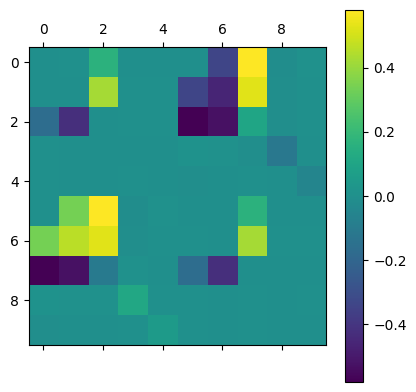

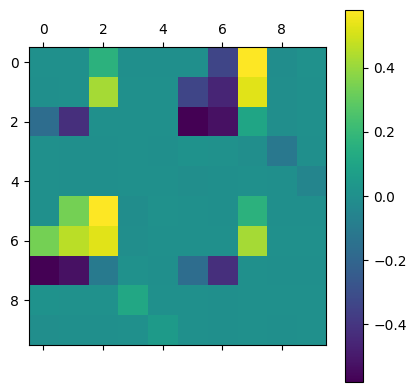

In [343]:
plt.matshow(target_kspace[0][1].imag)
plt.colorbar()

plt.matshow(rhk[0][1].imag)
plt.colorbar()

In [345]:
ifr = 0
for ik in range(len(rhk[ifr])):
    # print(torch.norm((rhk[ifr] - dataset.fock_kspace[ifr])[ik].imag))
    print(torch.norm((rhk[ifr] - target_kspace[ifr])[ik]))

tensor(2.4266e-09)
tensor(1.2507e-09)
tensor(2.2219e-09)
tensor(1.0268e-09)
tensor(1.9962e-09)
tensor(1.0268e-09)
tensor(2.2219e-09)
tensor(1.2507e-09)
tensor(1.6813e-09)
tensor(1.6615e-09)
tensor(1.5121e-09)
tensor(1.5023e-09)
tensor(1.3995e-09)
tensor(1.5906e-09)
tensor(1.5808e-09)
tensor(1.7418e-09)
tensor(1.9459e-09)
tensor(1.2410e-09)
tensor(1.6837e-09)
tensor(1.1258e-09)
tensor(1.6541e-09)
tensor(1.2266e-09)
tensor(1.9203e-09)
tensor(1.3332e-09)
tensor(1.6245e-09)
tensor(1.5872e-09)
tensor(1.5203e-09)
tensor(1.6005e-09)
tensor(1.4819e-09)
tensor(1.6837e-09)
tensor(1.5887e-09)
tensor(1.6711e-09)
tensor(2.0947e-09)
tensor(9.6951e-10)
tensor(2.0710e-09)
tensor(9.5101e-10)
tensor(2.0469e-09)
tensor(9.5101e-10)
tensor(2.0710e-09)
tensor(9.6951e-10)
tensor(1.6245e-09)
tensor(1.6711e-09)
tensor(1.5887e-09)
tensor(1.6837e-09)
tensor(1.4819e-09)
tensor(1.6005e-09)
tensor(1.5203e-09)
tensor(1.5872e-09)
tensor(1.9459e-09)
tensor(1.3332e-09)
tensor(1.9203e-09)
tensor(1.2266e-09)
tensor(1.654

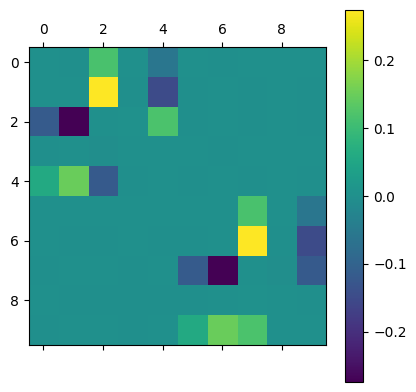

In [331]:
ifr = 0 
ik = 20
plt.matshow((rhk[ifr] - target_kspace[ifr])[ik].imag)
plt.colorbar()
# plt.matshow((rhk[ifr] - target_kspace[ifr])[ik].real)
# plt.colorbar()


In [272]:
ik = 1

In [325]:
print_matrix((rhk[ifr] - target_kspace[ifr])[ik].imag)

  -0.0000000000    0.0000172583    0.1991315719   -0.0000000722    0.1092567318    0.0000000000    0.0000000000   -0.0000000000    0.0000000000   -0.0000000000
  -0.0000172583    0.0000000000    0.4997162974    0.0000226156    0.2880915690    0.0000000000   -0.0000000000    0.0000000000   -0.0000000000    0.0000000001
  -0.1991315719   -0.4997162974    0.0000000000    0.0040790561   -0.0218255793    0.0000000000   -0.0000000000    0.0000000001   -0.0000000000   -0.0000000001
   0.0000000722   -0.0000226156   -0.0040790561   -0.0000000000   -0.0024442886   -0.0000000000    0.0000000000   -0.0000000000   -0.0000000000   -0.0000000000
  -0.1092567318   -0.2880915690    0.0218255793    0.0024442886    0.0000000000    0.0000000000   -0.0000000001   -0.0000000001   -0.0000000000   -0.0000000001
   0.0000000000    0.0000000000   -0.0000000000    0.0000000000   -0.0000000000   -0.0000000000   -0.0000173052    0.1991316124   -0.0000000721    0.1092567819
  -0.0000000000    0.0000000000    0.000

In [326]:
print_matrix((rhk[ifr][ik]).imag)# - target_kspace[ifr])[ik].imag)

   0.0000000000    0.0000000000    0.0000000000    0.0000000000    0.0000000000   -0.0000387139   -0.0286830299   -0.8720636303   -0.0010255835   -0.5414952376
   0.0000000000    0.0000000000    0.0000000000    0.0000000000    0.0000000000   -0.0286833311   -0.0319508846   -0.7193634764   -0.0005615539   -0.4295526863
   0.0000000000    0.0000000000    0.0000000000    0.0000000000    0.0000000000    0.8720638879    0.7193636015   -0.1436214695    0.0095335180    0.0804301284
   0.0000000000    0.0000000000    0.0000000000    0.0000000000    0.0000000000    0.0010255989    0.0005615474    0.0095333489   -0.0083192600    0.0056798751
   0.0000000000    0.0000000000    0.0000000000    0.0000000000    0.0000000000    0.5414957077    0.4295524838    0.0804298742    0.0056799635    0.1454973177
   0.0000387139    0.0286833311   -0.8720638879   -0.0010255989   -0.5414957077    0.0000000000    0.0000000000    0.0000000000    0.0000000000    0.0000000000
   0.0286830299    0.0319508846   -0.719

In [327]:
print_matrix((target_kspace[ifr])[ik].imag)

   0.0000000000   -0.0000172583   -0.1991315719    0.0000000722   -0.1092567318   -0.0000387139   -0.0286830299   -0.8720636303   -0.0010255835   -0.5414952376
   0.0000172583   -0.0000000000   -0.4997162974   -0.0000226156   -0.2880915690   -0.0286833311   -0.0319508846   -0.7193634764   -0.0005615539   -0.4295526864
   0.1991315719    0.4997162974   -0.0000000000   -0.0040790561    0.0218255793    0.8720638879    0.7193636015   -0.1436214696    0.0095335180    0.0804301286
  -0.0000000722    0.0000226156    0.0040790561    0.0000000000    0.0024442886    0.0010255989    0.0005615474    0.0095333489   -0.0083192600    0.0056798751
   0.1092567318    0.2880915690   -0.0218255793   -0.0024442886   -0.0000000000    0.5414957077    0.4295524838    0.0804298743    0.0056799635    0.1454973178
   0.0000387139    0.0286833311   -0.8720638879   -0.0010255989   -0.5414957077    0.0000000000    0.0000173052   -0.1991316124    0.0000000721   -0.1092567819
   0.0286830299    0.0319508846   -0.719

In [200]:
print_matrix((rhk[ifr] - target_kspace[ifr])[ik].real)

   0.0000000000    0.0000000000    0.0000000000    0.0000000000    0.0000000000    0.0000000000    0.0000000000   -0.0000000000   -0.0000000000    0.0000000000
   0.0000000000    0.0000000000    0.0000000000    0.0000000000   -0.0000000000    0.0000000000    0.0000000000   -0.0000000000    0.0000000000   -0.0000000000
   0.0000000000    0.0000000000    0.0000000000    0.0000000000   -0.0000000000    0.0000000000    0.0000000000   -0.0000000007    0.0000000000    0.0000000000
   0.0000000000    0.0000000000    0.0000000000    0.0000000000    0.0000000000    0.0000000000   -0.0000000000    0.0000000000    0.0000000000    0.0000000000
   0.0000000000   -0.0000000000   -0.0000000000    0.0000000000    0.0000000000   -0.0000000000    0.0000000000    0.0000000000    0.0000000000    0.0000000001
   0.0000000000   -0.0000000000    0.0000000000    0.0000000000   -0.0000000000    0.0000000000    0.0000000000   -0.0000000000   -0.0000000000    0.0000000000
   0.0000000000    0.0000000000    0.000

In [191]:
print_matrix((rhk[ifr][ik].imag/ target_kspace[ifr][ik].imag))

            nan             nan             nan             nan             nan             nan             nan             nan             nan             nan
            nan             nan             nan             nan             nan             nan             nan             nan             nan             nan
            nan             nan             nan             nan             nan             nan             nan             nan             nan             nan
            nan             nan             nan             nan             nan             nan             nan             nan             nan             nan
            nan             nan             nan             nan             nan             nan             nan             nan             nan             nan
            nan             nan             nan             nan             nan             nan             nan             nan             nan             nan
            nan             nan         

## Testset

In [5]:
# workdir = './'
workdir = './examples/data/periodic/c2-cp2k-benchmarks'
START = 3
STOP = 8
SKIP = 1
ORBS = 'sto-3g'
root = f'{workdir}'#/examples/data/periodic/c2/cp2k/sto-3g'
data_dir = root
frames = read(f'{data_dir}/C2_174.extxyz', slice(START, SKIP*STOP, SKIP))
rfock = [np.load(f"{data_dir}/C2_174_881_{i}/realfock_{i}.npy", allow_pickle = True).item() for i in range(START, SKIP*STOP, SKIP)]
rfock0_test = [np.load(f"{data_dir}/baseline/C2_174_881_{i}/realfock_{i}.npy", allow_pickle = True).item() for i in range(START, SKIP*STOP, SKIP)]
rover = [np.load(f"{data_dir}/C2_174_881_{i}/realoverlap_{i}.npy", allow_pickle = True).item() for i in range(START, SKIP*STOP, SKIP)]
# rover0 = [np.load(f"{data_dir}/baseline/C2_174_881_{i}/realoverlap_{i}.npy", allow_pickle = True).item() for i in range(START, STOP)]
kmesh = [8,8,1]

for f in frames:
    f.pbc = [True,True,False]
    f.wrap(center = (0,0,0), eps = 1e-60)
    f.pbc = True

# for K, K0 in zip(rfock, rfock0):
#     for T in K:
#         K[T] = K[T] - K0[T]
rfock_diff_test= []
for K, K0 in zip(rfock, rfock0_test):
    rfock_diff_test.append({})
    for T in K:
        rfock_diff_test[-1][T] = K[T] -K0[T]
        

testset = QMDataset(frames = frames, 
                               kmesh = kmesh, 
                               dimension = 2,
                               fock_realspace = rfock, 
                               overlap_realspace = rover, 
                               device = device, 
                               orbs = orbitals[ORBS], 
                               orbs_name = 'sto-3g')

FileNotFoundError: [Errno 2] No such file or directory: './examples/data/periodic/c2-cp2k-benchmarks/baseline/C2_174_881_3/realfock_3.npy'

In [ ]:
# for ifr in range(len(rover)):
#     for T in rover[ifr]:
#         print(ifr, T, np.linalg.norm(rover[ifr][T]- rover0[ifr][T]))

## Compute target

In [358]:
cutoff = 8
SORT_ORBS = True
target_blocks, target_coupled_blocks = get_targets(dataset, cutoff = cutoff, device = device, all_pairs = False, sort_orbs=SORT_ORBS)
_, overlap_coupled_blocks = get_targets(dataset, cutoff = cutoff, device = device, target = 'overlap')
target_blocks_base, target_coupled_blocks_base = get_targets(dataset, cutoff = cutoff, device = device, all_pairs = False, sort_orbs=SORT_ORBS, matrix=rfock_diff_target)
_, target_coupled_blocks_fock0 = get_targets(dataset, cutoff = cutoff, device = device, all_pairs = False, sort_orbs=SORT_ORBS, matrix=rfock0_target)
# target_kspace_base = dataset.bloch_sum(blocks_to_matrix(target_coupled_blocks_base, dataset))
# overlap_kspace = dataset.bloch_sum(blocks_to_matrix(overlap_coupled_blocks, dataset))

In [360]:
target_coupled_blocks_copy = target_coupled_blocks

In [8]:
_, test_coupled_blocks = get_targets(testset, cutoff = cutoff, device = device, all_pairs = False, sort_orbs=SORT_ORBS)
_, overlap_coupled_blocks_test = get_targets(dataset, cutoff = cutoff, device = device, target = 'overlap')
test_blocks_base, test_coupled_blocks_base = get_targets(testset, cutoff = cutoff, device = device, all_pairs = False, sort_orbs=SORT_ORBS, matrix=rfock_diff_test)
_, test_coupled_blocks_fock0 = get_targets(testset, cutoff = cutoff, device = device, all_pairs = False, sort_orbs=SORT_ORBS, matrix=rfock0_test )
# test_kspace = testset.bloch_sum(blocks_to_matrix(test_coupled_blocks, testset))
# test_kspace_base = testset.bloch_sum(blocks_to_matrix(test_coupled_blocks_base, testset))
# overlap_kspace_test = dataset.bloch_sum(blocks_to_matrix(overlap_coupled_blocks_test, testset))

In [349]:
target_kspace = dataset.bloch_sum(blocks_to_matrix(target_coupled_blocks, dataset))

In [350]:
target_kspace_copy = dataset.bloch_sum(blocks_to_matrix(target_coupled_blocks_copy, dataset))

In [351]:
for ifr in range(len(target_kspace)):
    # print(ifr, torch.norm(target_kspace[ifr] - target_kspace_copy[ifr]))
    print(ifr, torch.norm(target_kspace[ifr] - dataset.fock_kspace[ifr]))

0 tensor(1.2851e-08)
1 tensor(6.1799e-09)


In [371]:
kblocks_from_kmta2blo = _to_coupled_basis(kmatrix_to_blocks(dataset, cutoff = cutoff), translations = False)
phase, _,_=precompute_phase(target_coupled_blocks_copy, dataset)
kblocks_from_blochsum = TMap_bloch_sums(target_coupled_blocks_copy, phase)

/media/nigam/b5749eb7-d3f1-4495-adeb-2c318fb7d0de/MAC/mlelec/src/mlelec/utils/pbc_utils.py:1582: SyntaxWarning: invalid escape sequence '\d'
  


In [372]:
inter, m1, m2 = b1.samples.intersection_and_mapping(b.samples)

In [373]:
b1.samples.values[m1==-1]

tensor([[ 0,  0,  0,  0],
        [ 0,  1,  1,  0],
        [ 0,  0,  0,  1],
        ...,
        [ 1,  1,  1, 62],
        [ 1,  0,  0, 63],
        [ 1,  1,  1, 63]], dtype=torch.int32)

In [379]:
for k, b in sort_hack(kblocks_from_blochsum).items():
    b1 = sort_hack(kblocks_from_kmta2blo).block(k)
    assert b1.samples==b.samples
    print(torch.norm(b1.values - b.values))

tensor(1.4424e-15)
tensor(5.4670e-15)
tensor(4.3992e-09)
tensor(9.0633e-12)
tensor(4.9196e-14)
tensor(1.4159e-14)
tensor(2.4258e-15)
tensor(1.1339e-09)
tensor(1.8158e-12)
tensor(9.3038e-09)
tensor(1.3905e-08)


In [381]:
L2_loss(sort_hack(kblocks_from_blochsum), sort_hack(kblocks_from_kmta2blo))

tensor(3.0054e-16)

In [115]:
kmatrix_from_kblocks = kblocks_to_matrix(kblocks_from_blochsum, dataset)

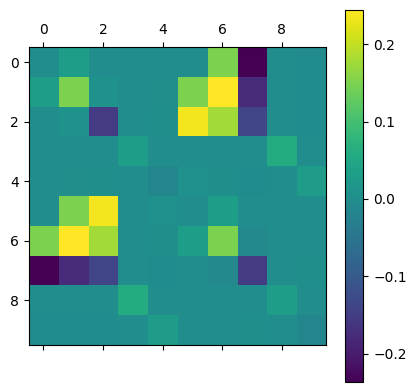

In [128]:
plt.matshow((kmatrix_from_kblocks[ifr][1] - target_kspace[1]).real[0])
plt.colorbar()

In [121]:
for ifr in range(len(kmatrix_from_kblocks)):
    for ik in range(len(kmatrix_from_kblocks[ifr])):
        # print(ifr, ik, torch.norm(kmatrix_from_kblocks[ifr][ik] - dataset.fock_kspace[ifr][ik]))
        print(ifr, ik, torch.norm(kmatrix_from_kblocks[ifr][ik] - target_kspace[ifr][ik]))
        # print(ifr, ik, torch.norm(kmatrix_from_kblocks[ifr] - target_kspace[ifr]))
        

0 0 tensor(2.4266e-09)
0 1 tensor(0.9066)
0 2 tensor(1.2507)
0 3 tensor(0.8624)
0 4 tensor(1.9962e-09)
0 5 tensor(0.8624)
0 6 tensor(1.2507)
0 7 tensor(0.9066)
0 8 tensor(0.9026)
0 9 tensor(1.2406)
0 10 tensor(1.1200)
0 11 tensor(0.5057)
0 12 tensor(0.5062)
0 13 tensor(1.1167)
0 14 tensor(1.2329)
0 15 tensor(0.8963)
0 16 tensor(1.2483)
0 17 tensor(1.1182)
0 18 tensor(0.7152)
0 19 tensor(0.3316)
0 20 tensor(0.7156)
0 21 tensor(1.1109)
0 22 tensor(1.2386)
0 23 tensor(1.2330)
0 24 tensor(0.8628)
0 25 tensor(0.5060)
0 26 tensor(0.3464)
0 27 tensor(0.3515)
0 28 tensor(0.5061)
0 29 tensor(0.8555)
0 30 tensor(1.1206)
0 31 tensor(1.1247)
0 32 tensor(2.0947e-09)
0 33 tensor(0.5205)
0 34 tensor(0.7356)
0 35 tensor(0.5202)
0 36 tensor(2.0469e-09)
0 37 tensor(0.5202)
0 38 tensor(0.7356)
0 39 tensor(0.5205)
0 40 tensor(0.8628)
0 41 tensor(1.1247)
0 42 tensor(1.1206)
0 43 tensor(0.8555)
0 44 tensor(0.5061)
0 45 tensor(0.3515)
0 46 tensor(0.3464)
0 47 tensor(0.5060)
0 48 tensor(1.2483)
0 49 tensor(1.

# Features 

In [6]:
max_radial  = 6
max_angular = 4
atomic_gaussian_width = 0.3
spline_basis = False

hypers_pair = {'cutoff': cutoff,
               'max_radial': max_radial,
               'max_angular': max_angular,
               'atomic_gaussian_width': atomic_gaussian_width,
               'center_atom_weight': 1,
               "radial_basis": {"Gto": {}},
               "cutoff_function": {"ShiftedCosine": {"width": 0.1}}}


hypers_atom = {'cutoff': 4,
               'max_radial': max_radial,
               'max_angular': max_angular,
               'atomic_gaussian_width': atomic_gaussian_width,
               'center_atom_weight': 1,
               "radial_basis": {"Gto": {}},
               "cutoff_function": {"ShiftedCosine": {"width": 0.1}}}


return_rho0ij = False
both_centers = False
LCUT = 3

hfeat = compute_features(dataset, hypers_atom, hypers_pair=hypers_pair, lcut = LCUT, all_pairs=False)

cpu pair features
cpu single center features
cpu single center features


In [11]:
hfeat_test = compute_features(testset, hypers_atom, hypers_pair=hypers_pair, lcut = LCUT, all_pairs=False)

cpu pair features


cpu single center features
cpu single center features


# Model

In [7]:
seed = 10
torch.manual_seed(seed)
np.random.seed(seed)
from mlelec.models.linear import LinearModelPeriodic
model = LinearModelPeriodic(twocfeat = hfeat, 
                            target_blocks = target_coupled_blocks,
                            frames = dataset.structures, orbitals = dataset.basis, 
                            device = device,
                            bias = False, #True
                            nhidden = 32, 
                            nlayers = 1,
                            # activation = 'SiLU',
                            # apply_norm = True
                           )

model = model.double()

## RIDGE models 

In [13]:
def train_ridge(model, target_blocks, set_bias=False, alphas = None, kernel_ridge = False, alpha = None):
    block_losses = {}
    loss = 0
    pred, ridges = model.fit_ridge_analytical(return_matrix = False, set_bias = set_bias, kernel_ridge = kernel_ridge, alphas = alphas, alpha = alpha)

    for (key, block) in pred.items():
        block_loss=torch.norm(block.values - target_blocks[key].values)**2
        loss += block_loss
        
        block_losses[tuple(key.values)] = block_loss

    # print(np.sum(list(block_losses.values())))
    return loss, pred, ridges, block_losses#, kernels 

### A - direct H(T)

In [14]:
model_ridge = LinearModelPeriodic(twocfeat = hfeat, 
                                  target_blocks = target_coupled_blocks,
                                  frames = dataset.structures, orbitals = dataset.basis, 
                                  device = device)

model_ridge = model_ridge.double()
loss_ridge_bias, pred_ridge_bias, ridges_bias, loss_blocks = train_ridge(model_ridge, 
                                                                         target_coupled_blocks,
                                                                         set_bias = True,
                                                                         kernel_ridge = False,
                                                                         # alphas = np.logspace(-10, -2, 100),
                                                                         alphas = np.logspace(-10, 1, 100),
                                                                         # alpha = 1e-4
                                                                        )
print(loss_ridge_bias)

tensor(3.1771e-06)


In [15]:
pred_test_ridge = model_ridge.predict_ridge_analytical(ridges_bias, hfeat_test)
L2_loss(test_coupled_blocks, pred_test_ridge)

/media/nigam/b5749eb7-d3f1-4495-adeb-2c318fb7d0de/MAC/mlelec/src/mlelec/models/linear.py:782: UserWarning: Using train target_blocks, otherwise provide test target_blocks
  warnings.warn('Using train target_blocks, otherwise provide test target_blocks')


tensor(0.0033)

### B. - baselined H(T)

In [16]:
model_ridge = LinearModelPeriodic(twocfeat = hfeat, 
                                  target_blocks = target_coupled_blocks_base,
                                  frames = dataset.structures, orbitals = dataset.basis, 
                                  device = device)

model_ridge = model_ridge.double()
loss_ridge_bias, pred_ridge_bias, ridges_bias, loss_blocks = train_ridge(model_ridge, 
                                                                         target_coupled_blocks_base,
                                                                         set_bias = True,
                                                                         kernel_ridge = False,
                                                                         # alphas = np.logspace(-10, -2, 100),
                                                                         alphas = np.logspace(-10, 1, 100),
                                                                         # alpha = 1e-4
                                                                        )
print(loss_ridge_bias)
pred_ht = mts.add(pred_ridge_bias, target_coupled_blocks_fock0)
L2_loss(pred_ht, target_coupled_blocks)

tensor(5.2701e-09)


tensor(5.2701e-09)

In [17]:
pred_test_ridge = model_ridge.predict_ridge_analytical(ridges_bias, hfeat_test)
# pred_ht = mts.add(pred_test_ridge, test_coupled_blocks_fock0)
# L2_loss(test_coupled_blocks, pred_ht)

/media/nigam/b5749eb7-d3f1-4495-adeb-2c318fb7d0de/MAC/mlelec/src/mlelec/models/linear.py:782: UserWarning: Using train target_blocks, otherwise provide test target_blocks
  warnings.warn('Using train target_blocks, otherwise provide test target_blocks')


### D. -  H(k)

In [48]:
from mlelec.utils.pbc_utils import precompute_phase, TMap_bloch_sums, TMap_bloch_sums_feat
phase, indices ,_= precompute_phase(hfeat, dataset)
hfeat_kspace = TMap_bloch_sums_feat(hfeat, phase, indices, _, return_tensormap=True)

In [49]:
# (target_coupled_blocks[4].values[0]*np.sqrt(2)+torch.sum(target_coupled_blocks[11].values[:38], axis=0))
# ((hfeat[0].values[0]*np.sqrt(2)+torch.sum(hfeat[7].values[:38], axis=0)) - hfeat_kspace[0].values[0]).norm()

In [50]:
phase, indices ,_= precompute_phase(target_coupled_blocks, dataset)
target_coupled_blocks_k = TMap_bloch_sums(target_coupled_blocks, phase, indices, _, return_tensormap=True)

In [51]:
kblocks = _to_coupled_basis(kmatrix_to_blocks(dataset, cutoff=cutoff),skip_symmetry = False, device = device, translations = False)

In [88]:
from mlelec.utils.metatensor_utils import sort_block_hack, sort_hack
for (k1, b1)in target_coupled_blocks_k.items():
    # b1 = sort_block_hack(b1)
    b2 = kblocks.block(k1)
    b2 = sort_block_hack(b2)
    # b2 = _match_feature_and_target_samples(b1, b2, return_idx=True)
    _,m1,m2 = b1.samples.intersection_and_mapping(b2.samples)
    b2val = b2.values[m2]
    assert torch.all(b1.samples.values[m1] == b2.samples.values[m2]), (b1.samples.values[m1], b2.samples.values[m2])
    # print(k1.values, b1.values.shape,b2.values.shape)
    print(k1.values, (b1.values-b2val).norm())

tensor([-1,  6,  1,  0,  6,  2,  0,  0], dtype=torch.int32) tensor(2.3452e-15)
tensor([-1,  6,  1,  0,  6,  2,  1,  1], dtype=torch.int32) tensor(8.6941e-15)
tensor([-1,  6,  2,  0,  6,  2,  1,  1], dtype=torch.int32) tensor(3.5022e-09)
tensor([-1,  6,  2,  1,  6,  2,  1,  1], dtype=torch.int32) tensor(7.3161e-14)
tensor([1, 6, 1, 0, 6, 1, 0, 0], dtype=torch.int32) tensor(8.5487e-14)
tensor([1, 6, 1, 0, 6, 2, 0, 0], dtype=torch.int32) tensor(2.3656e-14)
tensor([1, 6, 1, 0, 6, 2, 1, 1], dtype=torch.int32) tensor(3.7698e-15)
tensor([1, 6, 2, 0, 6, 2, 0, 0], dtype=torch.int32) tensor(1.6346e-09)
tensor([1, 6, 2, 0, 6, 2, 1, 1], dtype=torch.int32) tensor(2.5883e-11)
tensor([1, 6, 2, 1, 6, 2, 1, 0], dtype=torch.int32) tensor(1.3456e-08)
tensor([1, 6, 2, 1, 6, 2, 1, 2], dtype=torch.int32) tensor(2.0125e-08)


In [89]:
kblocks = sort_hack(kblocks)

In [54]:
model_ridge = LinearModelPeriodic(twocfeat = hfeat_kspace, 
                                  target_blocks = target_coupled_blocks_k,
                                  frames = dataset.structures, orbitals = dataset.basis, 
                                  device = device)

model_ridge = model_ridge.double()
loss_ridge_bias, pred_ridge_bias, ridges_bias, loss_blocks = train_ridge(model_ridge, 
                                                                         target_coupled_blocks_k,
                                                                         set_bias = True,
                                                                         kernel_ridge = False,
                                                                         alphas = np.logspace(-7, 2, 100),
                                                                        #  alphas = np.logspace(-6, 4, 100),
                                                                        #  alpha = 1e-4
                                                                        )
print(loss_ridge_bias)

tensor(0.0004)


(1e-10, 0.0005232541480597252)

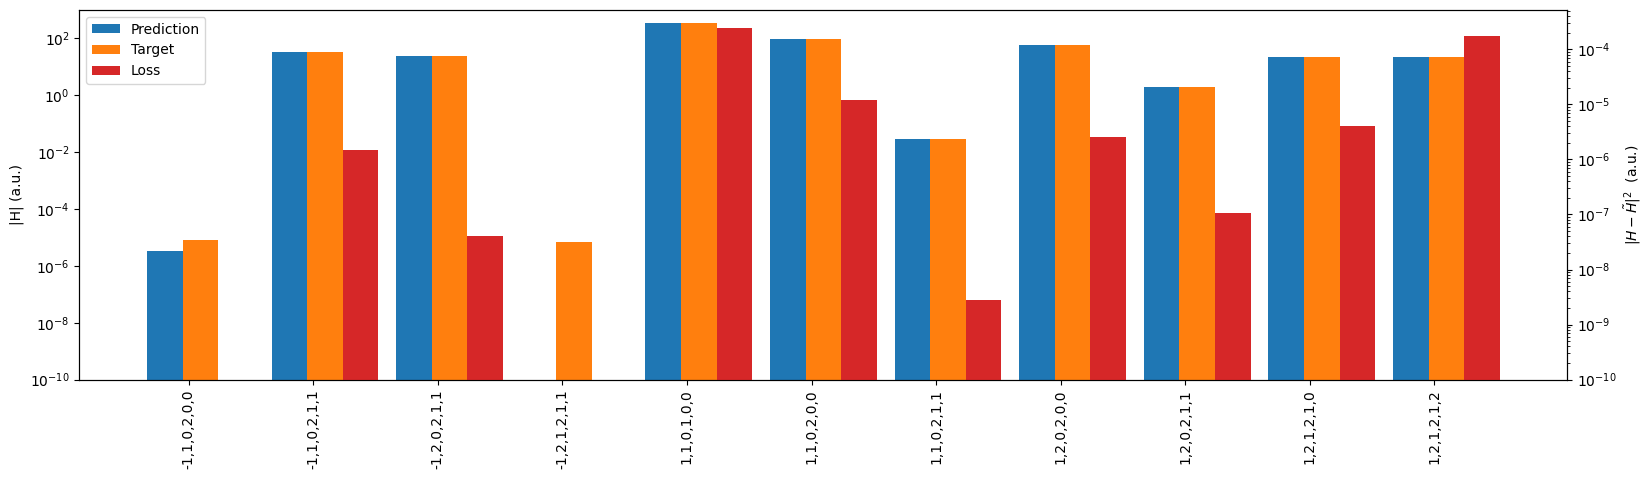

In [22]:
fig, ax, ax2 = plot_block_errors(target_coupled_blocks_k, pred_ridge_bias, plot_loss=True)
ax.set_ylim(1e-10,)
ax2.set_ylim(1e-10,)

In [92]:
model_ridge = LinearModelPeriodic(twocfeat = hfeat_kspace, 
                                  target_blocks = kblocks,
                                  frames = dataset.structures, orbitals = dataset.basis, 
                                  device = device)

model_ridge = model_ridge.double()
loss_ridge_bias, pred_ridge_bias, ridges_bias, loss_blocks = train_ridge(model_ridge, 
                                                                         kblocks,
                                                                         set_bias = True,
                                                                         kernel_ridge = False,
                                                                         alphas = np.logspace(-7, 2, 100),
                                                                        #  alphas = np.logspace(-6, 4, 100),
                                                                        #  alpha = 1e-4
                                                                        )
print(loss_ridge_bias)

tensor(0.0004)


### E. - baselined H(k)

In [22]:
phase, indices ,_= precompute_phase(target_coupled_blocks_base, dataset)
target_coupled_blocks_base_k = TMap_bloch_sums(target_coupled_blocks_base, phase, indices, _, return_tensormap=True)

In [23]:
model_ridge = LinearModelPeriodic(twocfeat = hfeat_kspace, 
                                  target_blocks = target_coupled_blocks_base_k,
                                  frames = dataset.structures, orbitals = dataset.basis, 
                                  device = device)

model_ridge = model_ridge.double()
loss_ridge_bias, pred_ridge_bias, ridges_bias, loss_blocks = train_ridge(model_ridge, 
                                                                         target_coupled_blocks_base_k,
                                                                         set_bias = True,
                                                                         kernel_ridge = False,
                                                                         alphas = np.logspace(-7, 2, 100),
                                                                        #  alphas = np.logspace(-6, 4, 100),
                                                                        #  alpha = 1e-4
                                                                        )
print(loss_ridge_bias)

tensor(7.4700e-07)


### G. - orthogonalize H(k) 

In [105]:
ortho_target_kspace =[]# torch.stack([lowdin_orthogonalize(h, s) for h, s in zip(ttarget_kspace, overlap_kspace)])
for ifr in range(len(target_kspace)):
    ot = torch.stack([lowdin_orthogonalize(h, s) for h, s in zip(target_kspace[ifr], overlap_kspace[ifr])])
    ortho_target_kspace.append(ot)

In [106]:
e_ortho=[]
for ifr in range(len(ortho_target_kspace)):
   eifr=[]
   for k in range(len(ortho_target_kspace[ifr])):
      eifr.append(torch.linalg.eigvalsh(ortho_target_kspace[ifr][k]))
   e_ortho.append(torch.stack(eifr))

In [107]:
import scipy
e_nonorth=[]
for ifr in range(len(target_kspace)):
   eifr=[]
   for k in range(len(target_kspace[ifr])):
      eifr.append(torch.tensor(scipy.linalg.eigvalsh(target_kspace[ifr][k], overlap_kspace[ifr][k])))
   e_nonorth.append(torch.stack(eifr))

In [108]:
for ifr in range(len(dataset)):
    print(ifr, torch.norm(e_ortho[ifr]-e_nonorth[ifr]))

0 tensor(1.3181e-13)
1 tensor(1.3615e-13)
2 tensor(1.4274e-13)
3 tensor(1.1559e-13)
4 tensor(1.1993e-13)


In [62]:
# plt.plot(torch.cat(e_ortho).numpy(), torch.cat(e_nonorth).numpy(), 'o')

In [109]:
oblocks = _to_coupled_basis(kmatrix_to_blocks(dataset, cutoff=cutoff, matrix = ortho_target_kspace),skip_symmetry = False, device = device, translations = False)
oblocks = sort_hack(oblocks)

In [114]:
model_ridge = LinearModelPeriodic(twocfeat = hfeat_kspace, 
                                  target_blocks = oblocks,
                                  frames = dataset.structures, orbitals = dataset.basis, 
                                  device = device)

model_ridge = model_ridge.double()
loss_ridge_bias, pred_ridge_bias, ridges_bias, loss_blocks = train_ridge(model_ridge, 
                                                                         oblocks,
                                                                         set_bias = True,
                                                                         kernel_ridge = False,
                                                                         alphas = np.logspace(-20,4, 100),
                                                                        #  alphas = np.logspace(-6, 4, 100),
                                                                        #  alpha = 1e-4
                                                                        )
print(loss_ridge_bias)

tensor(10058.2337)


(1e-10, 5432.72529376023)

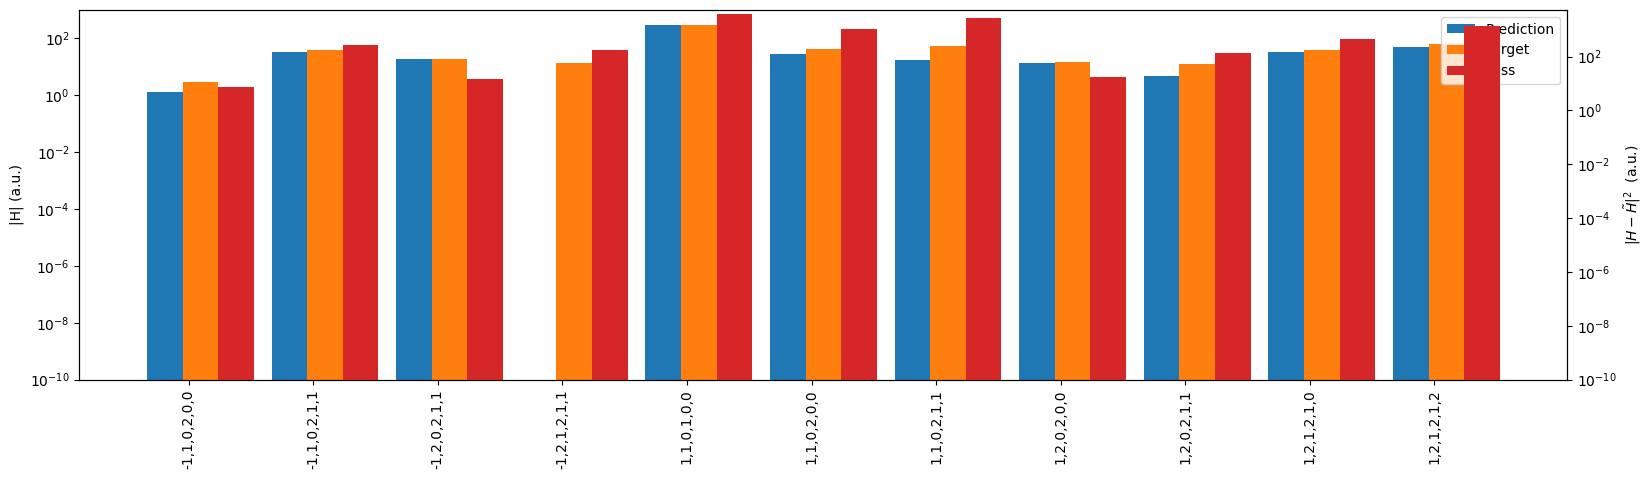

In [115]:
fig, ax, ax2 = plot_block_errors(oblocks, pred_ridge_bias, plot_loss=True)
ax.set_ylim(1e-10,)
ax2.set_ylim(1e-10,)

### H. - orthogonalize baseline

In [100]:
ortho_target_kspace_base =[]# torch.stack([lowdin_orthogonalize(h, s) for h, s in zip(ttarget_kspace, overlap_kspace)])
for ifr in range(len(target_kspace)):
    ot = torch.stack([lowdin_orthogonalize(h, s) for h, s in zip(target_kspace_base[ifr], overlap_kspace[ifr])])
    ortho_target_kspace_base.append(ot)

In [101]:
oblocks_base = _to_coupled_basis(kmatrix_to_blocks(dataset, cutoff=cutoff, matrix = ortho_target_kspace_base),skip_symmetry = False, device = device, translations = False)
oblocks_base = sort_hack(oblocks_base)

In [104]:
model_ridge = LinearModelPeriodic(twocfeat = hfeat_kspace, 
                                  target_blocks = oblocks_base,
                                  frames = dataset.structures, orbitals = dataset.basis, 
                                  device = device)

model_ridge = model_ridge.double()
loss_ridge_bias, pred_ridge_bias, ridges_bias, loss_blocks = train_ridge(model_ridge, 
                                                                         oblocks_base,
                                                                         set_bias = True,
                                                                         kernel_ridge = False,
                                                                         alphas = np.logspace(-7,2, 100),
                                                                        #  alphas = np.logspace(-6, 4, 100),
                                                                        #  alpha = 1e-4
                                                                        )
print(loss_ridge_bias)

tensor(0.6547)


## Torch

In [11]:
from mlelec.utils.pbc_utils import TMap_bloch_sums, precompute_phase
from copy import deepcopy

In [8]:
target_keynames = target_coupled_blocks.keys.names
keys = []
blocks= []
for k,b in target_coupled_blocks.items(): 
    li,lj, L = k['l_i'], k['l_j'], k['L']
    inversion_sigma = (-1) ** (li + lj + L)
    keys.append(torch.cat((k.values, torch.tensor([inversion_sigma]))))
    blocks.append(b.copy())
target_coupled_blocks = TensorMap( Labels(k.names+['inversion_sigma'], torch.stack(keys)), blocks)
                 
target_coupled_blocks_copy = target_coupled_blocks.copy()
target_coupled_blocks = target_coupled_blocks.keys_to_properties(['n_i', 'l_i',  'n_j','l_j'])

In [74]:
phase, _,_ = precompute_phase(target_coupled_blocks, dataset)
target_k = TMap_bloch_sums(target_coupled_blocks, phase)
phase, _,_ = precompute_phase(target_coupled_blocks_copy, dataset)
target_k_copy = TMap_bloch_sums(target_coupled_blocks_copy, phase)

In [68]:
# for k,b in target_k_copy.items():
for k,b in move_orbitals_to_keys(target_k).items():
    k1 = Labels(k.names[:-1], k.values[:-1].reshape(1,-1))
    b1 = kblocks_from_blochsum.block(k1)
    b = sort_block_hack(b)
    b1 = sort_block_hack(b1)
    assert torch.all(b.samples.values == b1.samples.values)
    print( torch.norm(b.values- b1.values))

tensor(1.4420e-15)
tensor(5.9375e-15)
tensor(2.2834e-09)
tensor(5.7608e-14)
tensor(4.9196e-14)
tensor(1.4256e-14)
tensor(1.1339e-09)
tensor(9.3038e-09)
tensor(2.4258e-15)
tensor(1.8158e-12)
tensor(1.3905e-08)


/media/nigam/b5749eb7-d3f1-4495-adeb-2c318fb7d0de/MAC/mlelec/src/mlelec/utils/pbc_utils.py:289: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  keys.append(torch.hstack((k.values, torch.tensor(nlinlj))))


In [69]:
from mlelec.models.linear_integrated import LinearModelPeriodic

In [76]:
model = LinearModelPeriodic(twocfeat = hfeat,
                            target_blocks = target_coupled_blocks,
                            frames = dataset.structures, orbitals = dataset.basis, 
                            device = device,
                            bias = False, #True
                            nhidden = 64, 
                            nlayers = 1,
                            # activation = 'SiLU',
                            # apply_norm = True
                           )

In [77]:
optim = torch.optim.Adam(model.parameters(), lr = 1e-3)

In [78]:
losses = []

In [87]:
# losses = []
for epoch in range(5000):
    optim.zero_grad()
    pred = model()
    # print(pred.keys, phase.keys())
    predk = TMap_bloch_sums(pred, phase)
    # loss = L2_loss(target_coupled_blocks, pred)
    loss = L2_loss(target_k, predk)
    loss.backward()
    losses.append(loss.item())
    optim.step()    
    if epoch%100 == 0 :
        print(epoch, loss.item(), L2_loss(target_coupled_blocks, pred).item())
        

Labels(
    block_type  species_i  species_j  L  inversion_sigma
        -1          6          6      0         1
        -1          6          6      1         1
                            ...
        1           6          6      1         1
        1           6          6      2         1
) dict_keys([(-1, 6, 6, 0, 1), (-1, 6, 6, 1, 1), (-1, 6, 6, 1, -1), (0, 6, 6, 0, 1), (0, 6, 6, 1, 1), (0, 6, 6, 2, 1), (1, 6, 6, 0, 1), (1, 6, 6, 1, 1), (1, 6, 6, 2, 1)])
0 0.009071787352785333 0.43237556019041307
Labels(
    block_type  species_i  species_j  L  inversion_sigma
        -1          6          6      0         1
        -1          6          6      1         1
                            ...
        1           6          6      1         1
        1           6          6      2         1
) dict_keys([(-1, 6, 6, 0, 1), (-1, 6, 6, 1, 1), (-1, 6, 6, 1, -1), (0, 6, 6, 0, 1), (0, 6, 6, 1, 1), (0, 6, 6, 2, 1), (1, 6, 6, 0, 1), (1, 6, 6, 1, 1), (1, 6, 6, 2, 1)])
Labels(
    block_typ

KeyboardInterrupt: 

In [ ]:
# plt.plot(losses)
plt.loglog(losses)

In [81]:
from mlelec.utils.pbc_utils import move_orbitals_to_keys

In [88]:
pred_int = model()
# pred_int = move_orbitals_to_keys(pred_int, target_coupled_blocks_copy[0].properties)
print(L2_loss(pred_int, target_coupled_blocks))
aa = move_orbitals_to_keys(pred_int, target_coupled_blocks_copy[0].properties)
print(L2_loss(aa,target_coupled_blocks_copy))

tensor(0.4321, grad_fn=<AddBackward0>)
tensor(0.4321, grad_fn=<AddBackward0>)


/media/nigam/b5749eb7-d3f1-4495-adeb-2c318fb7d0de/MAC/mlelec/src/mlelec/utils/pbc_utils.py:289: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  keys.append(torch.hstack((k.values, torch.tensor(nlinlj))))


In [90]:
# pred_int = model()
predk = TMap_bloch_sums(pred_int, phase)
# pred_int = move_orbitals_to_keys(pred_int, target_coupled_blocks_copy[0].properties)
print(f'loss_real = {L2_loss(pred, target_coupled_blocks).item():.5f}, loss_k = {L2_loss(predk, target_k).item():.5f}')

loss_real = 0.43221, loss_k = 0.01222


Reconstruct matrices from real space blocks

In [112]:
# recon_Hk = kblocks_to_matrix(predk, dataset, detach = True)
recon_Hk = kblocks_to_matrix(target_k, dataset, detach = True)
# recon_HT = blocks_to_matrix(pred_int, dataset, detach=True)

In [113]:
print('kspace')
for ifr in range(len(recon_Hk)):
    print(ifr, torch.norm(recon_Hk[ifr] - target_kspace[ifr]))

# print(L2_loss(predk, target_k))

kspace
0 tensor(7.0550)
1 tensor(6.4099)
tensor(0.)


In [109]:
print('realspace')
for ifr in range(len(recon_HT)):
    for T in recon_HT[ifr]:
        print(ifr, T, torch.norm(recon_HT[ifr][T] - dataset.fock_realspace[ifr][T]))
# L2_loss(pred, target_coupled_blocks)

kspace 0 tensor(7.0550)
kspace 1 tensor(6.4099)
tensor(0.0122, grad_fn=<AddBackward0>)
realspace
0 (-3, -3, 0) tensor(0.0021)
0 (3, 3, 0) tensor(0.0021)
0 (-3, -2, 0) tensor(0.0033)
0 (3, 2, 0) tensor(0.0033)
0 (-3, -1, 0) tensor(0.0036)
0 (3, 1, 0) tensor(0.0036)
0 (-3, 0, 0) tensor(0.0020)
0 (3, 0, 0) tensor(0.0020)
0 (-2, -4, 0) tensor(0.0015)
0 (2, 4, 0) tensor(0.0015)
0 (-2, -3, 0) tensor(0.0032)
0 (2, 3, 0) tensor(0.0032)
0 (-2, -2, 0) tensor(0.0076)
0 (2, 2, 0) tensor(0.0076)
0 (-2, -1, 0) tensor(0.0084)
0 (2, 1, 0) tensor(0.0084)
0 (-2, 0, 0) tensor(0.0069)
0 (2, 0, 0) tensor(0.0069)
0 (-2, 1, 0) tensor(0.0033)
0 (2, -1, 0) tensor(0.0033)
0 (-1, -3, 0) tensor(0.0034)
0 (1, 3, 0) tensor(0.0034)
0 (-1, -2, 0) tensor(0.0086)
0 (1, 2, 0) tensor(0.0086)
0 (-1, -1, 0) tensor(0.1913)
0 (1, 1, 0) tensor(0.1913)
0 (-1, 0, 0) tensor(0.1898)
0 (1, 0, 0) tensor(0.1898)
0 (-1, 1, 0) tensor(0.0095)
0 (1, -1, 0) tensor(0.0095)
0 (-1, 2, 0) tensor(0.0033)
0 (1, -2, 0) tensor(0.0033)
0 (0, -3, 

Reconstruct matrices from kspace blocks

In [477]:
predintk = move_orbitals_to_keys(predk, target_coupled_blocks_copy[0].properties)
predintk = mts.remove_dimension(predintk, axis='keys', name = 'inversion_sigma')
predintk = mts.permute_dimensions(predintk, axis='keys', dimensions_indexes = [0,1,4,5,2,6,7,3])
predintk = _to_uncoupled_basis(predintk)
newb=[]
for k,b in predintk.items():
    newb.append(
        TensorBlock(
            samples = b.samples,
            components = b.components,
            properties = b.properties,
            values = b.values.detach()
        )
    )
predintk = TensorMap(predintk.keys, newb)
predintk = sort_hack(predintk)

In [478]:
recon_Hk_from_ktarg = kblocks_to_matrix(predintk, dataset, detach = True)

Target matrices with cutoff

In [479]:
cutoff_HT = blocks_to_matrix(target_coupled_blocks_copy_nosigma, dataset, detach=True)
cutoff_Hk = dataset.bloch_sum(cutoff_HT)

MSE on H(T)

In [480]:
tot_mse = 0
for ifr in range(len(recon_HT)):
    for T in recon_HT[ifr]:
        # print(torch.norm(recon_HT[ifr][T] - cutoff_HT[ifr][T]))
        tot_mse += torch.norm(recon_HT[ifr][T] - cutoff_HT[ifr][T])**2
print(tot_mse)

tensor(0.2908)


MSE on H(k) computed from H(T)

In [481]:
tot_mse = 0
for ifr in range(len(recon_Hk)):
    for ik in range(len(recon_Hk[ifr])):
        # print(torch.norm(recon_Hk[ifr][ik] - cutoff_Hk[ifr][ik]))
        tot_mse += torch.norm(recon_Hk[ifr][ik] - cutoff_Hk[ifr][ik])**2
print(tot_mse/64)

tensor(0.2908)


MSE on H(k) computed from kspace blocks

In [482]:
tot_mse = 0
for ifr in range(len(recon_Hk_from_ktarg)):
    for ik in range(len(recon_Hk_from_ktarg[ifr])):
        # print(torch.norm(recon_Hk[ifr][ik] - cutoff_Hk[ifr][ik]))
        tot_mse += torch.norm(recon_Hk_from_ktarg[ifr][ik] - cutoff_Hk[ifr][ik])**2
print(tot_mse/64)

tensor(1.4198)


In [485]:
kblocks = kmatrix_to_blocks(dataset, cutoff = cutoff)
kblocks = sort_hack(kblocks)

In [521]:
phase, _, _ = precompute_phase(target_coupled_blocks_copy_nosigma, dataset)
kblocks = TMap_bloch_sums(target_coupled_blocks_copy_nosigma, phase)
kblocks = sort_hack(kblocks)
kblocks = _to_uncoupled_basis(kblocks)

In [522]:
rHk = kblocks_to_matrix(kblocks, dataset)

In [523]:
for h1, h2 in zip(rHk, cutoff_Hk):
    print(torch.norm(h1-h2))

tensor(7.0550)
tensor(6.4099)


# Is there an issue with kblocks_to_matrix?

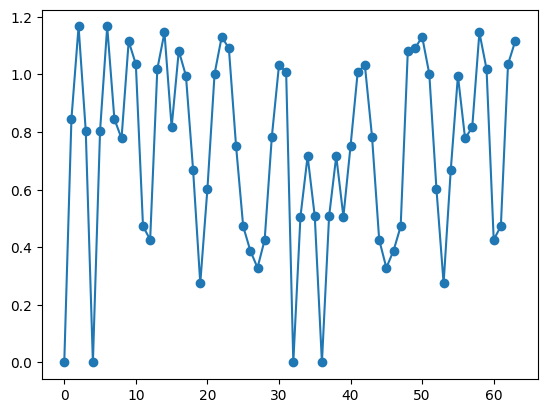

In [509]:
plt.plot(torch.norm(rHk[1] - cutoff_Hk[1], dim=(1,2)), '-o')

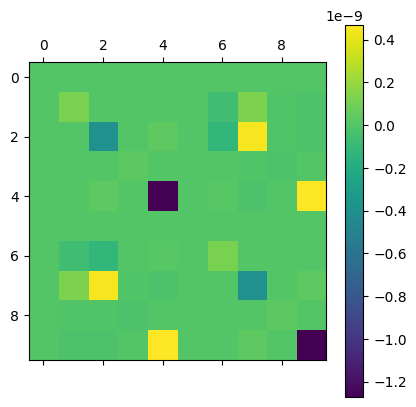

In [499]:
plt.matshow((rHk[0] - cutoff_Hk[0]).real[6])
plt.colorbar()

In [401]:
L2_loss(predint, target_blocks)

tensor(0.3217, grad_fn=<AddBackward0>)

In [465]:
L2_loss(predintk, target_k)

tensor(0.0136)

In [299]:
from mlelec.utils.twocenter_utils import _to_uncoupled_basis

In [326]:
# target_coupled_blocks_copy= mts.remove_dimension(target_coupled_blocks_copy, axis='keys', name = 'inversion_sigma')
phase,_,_ = precompute_phase(target_coupled_blocks_copy, dataset, cutoff = cutoff)
target_k_copy = TMap_bloch_sums(target_coupled_blocks_copy, phase)
# target_k_copy= _to_uncoupled_basis(target_k_copy)

/media/nigam/b5749eb7-d3f1-4495-adeb-2c318fb7d0de/MAC/mlelec/src/mlelec/utils/pbc_utils.py:1578: SyntaxWarning: invalid escape sequence '\d'
  assert np.isclose(torch.norm(matrixT - matrixmT.T).item(), 0.0), f"Failed to check H({T}) = H({mT})^\dagger"


In [304]:
Hk = dataset.bloch_sum( blocks_to_matrix(target_coupled_blocks_copy, dataset))
Hkblocks = kmatrix_to_blocks(dataset, matrix= Hk, cutoff = cutoff)

In [317]:
Hkblocks = _to_coupled_basis(Hkblocks,skip_symmetry = False, device = device, translations = False)

In [327]:
Hkblocks = sort_hack(Hkblocks)
target_k_copy = sort_hack(target_k_copy)

In [329]:
L2_loss(Hkblocks, target_k_copy)

tensor(2.3506e-27)

In [254]:
newb = []
for k, b in predk.items():
    newb.append(
        TensorBlock(
            values = b.values.detach(),
            samples = b.samples,
            properties = b.properties,
            components = b.components
        )
    )
predk = TensorMap(predk.keys, newb)
kblocks_to_matrix(move_orbitals_to_keys(predk), dataset)

/media/nigam/b5749eb7-d3f1-4495-adeb-2c318fb7d0de/MAC/mlelec/src/mlelec/utils/pbc_utils.py:288: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  keys.append(torch.hstack((k.values, torch.tensor(nlinlj))))
/media/nigam/b5749eb7-d3f1-4495-adeb-2c318fb7d0de/MAC/mlelec/src/mlelec/utils/pbc_utils.py:864: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3675.)
  recon_Hk[A][ik][ipsi_jphi] -= blockval.T


RuntimeError: output with shape [3, 1] doesn't match the broadcast shape [3, 3]

In [215]:
pred_int = model()
print(L2_loss(pred_int, target_coupled_blocks))


tensor(0.1688, grad_fn=<AddBackward0>)


In [182]:
from mlelec.models.linear import LinearModelPeriodic

In [183]:
model_ = LinearModelPeriodic(twocfeat = hfeat,
                            target_blocks = target_coupled_blocks_copy,
                            frames = dataset.structures, orbitals = dataset.basis, 
                            device = device,
                            bias = False, #True
                            nhidden = 32, 
                            nlayers = 1,
                            # activation = 'SiLU',
                            # apply_norm = True
                           )

In [184]:
optim = torch.optim.Adam(model_.parameters(), lr = 1e-3)

In [185]:
losses = []

In [220]:

aa = TMap_bloch_sums(target_coupled_blocks, phase)

/media/nigam/b5749eb7-d3f1-4495-adeb-2c318fb7d0de/MAC/mlelec/src/mlelec/utils/pbc_utils.py:1578: SyntaxWarning: invalid escape sequence '\d'
  


In [222]:
phase, _,_ = precompute_phase(target_coupled_blocks_copy, dataset)
bb = TMap_bloch_sums(target_coupled_blocks_copy, phase)

In [224]:
bb = bb.keys_to_properties(['n_i', 'l_i', 'n_j', 'l_j'])

In [229]:
for k,b in aa.items():
    b1 = bb.block(k)
    print(k.values, torch.norm(b.values -b1.values))

tensor([-1,  6,  6,  0,  1], dtype=torch.int32) tensor(0.)
tensor([-1,  6,  6,  1,  1], dtype=torch.int32) tensor(4.2911e-15)
tensor([-1,  6,  6,  1, -1], dtype=torch.int32) tensor(0.)
tensor([1, 6, 6, 0, 1], dtype=torch.int32) tensor(4.9512e-15)
tensor([1, 6, 6, 1, 1], dtype=torch.int32) tensor(2.4876e-16)
tensor([1, 6, 6, 2, 1], dtype=torch.int32) tensor(0.)


In [186]:
# losses = []
for epoch in range(1000):
    optim.zero_grad()
    pred = model_()
    predk = TMap_bloch_sum()
    loss = L2_loss(target_coupled_blocks_copy, pred)
    loss.backward()
    losses.append(loss.item())
    optim.step()    
    if epoch%100 == 0 :
        print(epoch, loss.item())
        

0 439.3994054418858
100 0.4414633975697585
200 0.2822832034394895
300 0.266793472882711
400 0.2574123133521787
500 0.2480742882327524
600 0.23856387664073453
700 0.22887443760194875
800 0.21904249604680132
900 0.20911100070352784


In [198]:
count_parameters(model_.model['(-1, 6, 1, 0, 6, 2, 0, 0, 1)'])

5792

In [201]:
count_parameters(model_)

135360

In [214]:
count_parameters(model)/count_parameters(model_)

1.0808510638297872

In [192]:
(288*32+32)*2

18496

In [194]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [195]:
count_parameters(model.model[])

73152

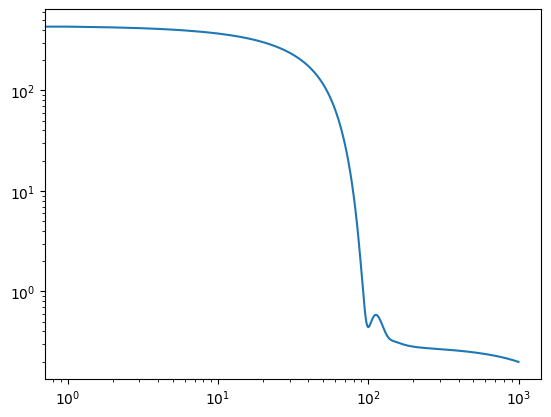

In [187]:
# plt.plot(losses)
plt.loglog(losses)

In [189]:
pred_usual = model_()
# pred_usual = move_orbitals_to_keys(pred_usual, target_coupled_blocks_copy[0].properties)
print(L2_loss(pred_usual, target_coupled_blocks_copy))

tensor(0.1991, grad_fn=<AddBackward0>)


In [87]:
from mlelec.utils.metatensor_utils import sort_block_hack, sort_hack

### Batching

In [58]:
split_by_axis = "samples"
split_by_dimension = "structure"

split_by_axis = "samples"
split_by_dimension = "structure"

grouped_labels = [mts.Labels(names = split_by_dimension, values = torch.tensor([A])) for A in mts.unique_metadata(target_coupled_blocks,
                                                                                                                  axis = split_by_axis,
                                                                                                                  names = split_by_dimension)]
split_target = mts.split(target_coupled_blocks, split_by_axis, grouped_labels)

grouped_labels = [mts.Labels(names = split_by_dimension, values = torch.tensor([A])) for A in mts.unique_metadata(overlap_coupled_blocks,
                                                                                                                  axis = split_by_axis,
                                                                                                                  names = split_by_dimension)]
#split_overlaps = mts.split(overlap_coupled_blocks, split_by_axis, grouped_labels)

grouped_labels = [mts.Labels(names = split_by_dimension, values = torch.tensor([A])) for A in mts.unique_metadata(hfeat, axis = split_by_axis,
                                                                                                                  names = split_by_dimension)]
split_features = mts.split(hfeat, split_by_axis, grouped_labels)

ml_data = IndexedDataset(descriptor = split_features,
                         target = split_target,
                         target_k = target_kspace,
                         sample_id = [g.values.tolist()[0][0] for g in grouped_labels])

batch_size = 1

from metatensor.learn import DataLoader
dataloader = DataLoader(ml_data,
                        batch_size = batch_size,
                        shuffle = True,
                        collate_fn = lambda x: group_and_join_mts(x, join_kwargs = {'different_keys': 'union', 'remove_tensor_name': True}))


# Splitting dataset random seed on jed 

In [ ]:
f=[]
for i in range(7):
    f.append(mts.load(f'features_{i*20}_{(i+1)*20}'))
f.append(mts.load('../test/features_140_172'))
np.random.seed(73)
indices = np.arange(172)
np.random.shuffle(indices)
np.savetxt('random_indices.txt', indices, header = 'seed = 73', fmt = '%d')
batched = {}
for i in range(0,7):
    selid = indices[i*20:20*(i+1)]
    batched[i]=[]
    for iid in selid:
        # batched[i].append(iid)
        batched[i].append(split_features[iid])
batched[8]=[]
selid = indices[140:]
for iid in selid:
    # batched[i].append(iid)
    batched[i].append(split_features[iid])


for i in batched.keys(): 
    features = mts.join(batched[i], axis='samples')
    blocks = []
    for k, b in features.items():
            sample_values = b.samples.values
            sample_values[:, 0] = sample_values[:, 6]
            samples = mts.Labels(b.samples.names[:-1], sample_values[:, :-1])
            blocks.append(mts.TensorBlock(
            values = b.values,
            samples = samples,
            properties = b.properties,
            components = b.components
            ))
    features = mts.TensorMap(features.keys, blocks)
    features.save(f'features_{i*20}_{(i+1)*20}_seed73')